In [1]:
from fastai import *
from fastai.collab import *

In [2]:
path = untar_data(URLs.ML_SAMPLE)
path

PosixPath('/tmp/.fastai/data/movie_lens_sample')

In [3]:
ratings = pd.read_csv(path/'ratings.csv')
series2cat(ratings,'userId','movieId')
ratings.head()

,userId,movieId,rating,timestamp
0,73,1097,4.0,1255504951
1,561,924,3.5,1172695223
2,157,260,3.5,1291598691
3,358,1210,5.0,957481884
4,130,316,2.0,1138999234


In [4]:
y_range = [0,5.5]

In [5]:
data = CollabDataBunch.from_df(ratings, seed=42)

In [6]:
learn = collab_learner(data, n_factors=50, y_range=y_range)

In [7]:
learn.fit_one_cycle(4, 5e-3)

epoch,train_loss,valid_loss,time
0,1.771183,1.339464,00:00
1,0.903121,0.664282,00:00
2,0.660713,0.650737,00:00
3,0.573084,0.649409,00:00


In [8]:
folder = '../input/ml-100k/ml-100k'
path = Path(folder)
os.listdir(folder)

['ub.base',
 'u.info',
 'u.occupation',
 'README',
 'u2.base',
 'ub.test',
 'mku.sh',
 'u5.base',
 'u1.base',
 'u.data',
 'allbut.pl',
 'u2.test',
 'ua.test',
 'ua.base',
 'u3.test',
 'u1.test',
 'u3.base',
 'u4.test',
 'u5.test',
 'u.genre',
 'u.user',
 'u.item',
 'u4.base']

In [9]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      names=['userId','movieId','rating','timestamp'])
ratings.head()

,userId,movieId,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [10]:
movies = pd.read_csv(path/'u.item', delimiter='|', encoding = 'latin-1', 
                     header=None, names=['movieId', 'title', 'date', 'N', 'url', 
                                         *[f'g{i}' for i in range(19)]])
movies.head()

,movieId,title,date,N,url,g0,g1,g2,g3,g4,g5,g6,g7,g8,g9,g10,g11,g12,g13,g14,g15,g16,g17,g18
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [11]:
len(ratings)

100000

In [12]:
rating_movie = ratings.merge(movies[['movieId', 'title']])
rating_movie.head()

,userId,movieId,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


In [13]:
data = CollabDataBunch.from_df(rating_movie, seed=42, valid_pct=0.1, item_name='title')
data.show_batch()

userId,title,target
833,Nikita (La Femme Nikita) (1990),4.0
456,"Funeral, The (1996)",3.0
351,Alien: Resurrection (1997),3.0
177,Tank Girl (1995),3.0
130,Batman (1989),5.0


In [14]:
y_range = [0,5.5]

In [15]:
learn = collab_learner(data, n_factors=40, y_range=y_range, wd=1e-1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


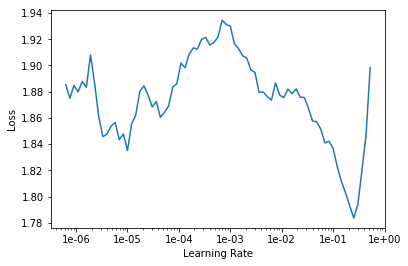

In [16]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [17]:
learn.fit_one_cycle(5,5e-3)

epoch,train_loss,valid_loss,time
0,0.947620,0.942242,00:09
1,0.836247,0.883801,00:09
2,0.750398,0.831993,00:09
3,0.642451,0.813066,00:09
4,0.560257,0.811882,00:09


In [18]:
learn.save('dotprod')

In [19]:
learn.load('dotprod')

CollabLearner(data=TabularDataBunch;

Train: LabelList (90000 items)
x: CollabList
userId 196; title Kolya (1996); ,userId 63; title Kolya (1996); ,userId 226; title Kolya (1996); ,userId 154; title Kolya (1996); ,userId 306; title Kolya (1996); 
y: FloatList
3.0,3.0,5.0,3.0,5.0
Path: .;

Valid: LabelList (10000 items)
x: CollabList
userId 498; title Casino (1995); ,userId 642; title Pocahontas (1995); ,userId 58; title 2001: A Space Odyssey (1968); ,userId 495; title Cat People (1982); ,userId 618; title Philadelphia (1993); 
y: FloatList
3.0,5.0,4.0,3.0,3.0
Path: .;

Test: None, model=EmbeddingDotBias(
  (u_weight): Embedding(944, 40)
  (i_weight): Embedding(1654, 40)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1654, 1)
), opt_func=functools.partial(<class 'torch.optim.adam.Adam'>, betas=(0.9, 0.99)), loss_func=FlattenedLoss of MSELoss(), metrics=[], true_wd=True, bn_wd=True, wd=0.1, train_bn=True, path=PosixPath('.'), model_dir='models', callback_fns=[functools.partial(<clas

In [20]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(944, 40)
  (i_weight): Embedding(1654, 40)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1654, 1)
)

In [21]:
g=rating_movie.groupby('title')['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_movies[:10]

array(['Star Wars (1977)', 'Contact (1997)', 'Fargo (1996)', 'Return of the Jedi (1983)', 'Liar Liar (1997)',
       'English Patient, The (1996)', 'Scream (1996)', 'Toy Story (1995)', 'Air Force One (1997)',
       'Independence Day (ID4) (1996)'], dtype=object)

In [22]:
movie_bias = learn.bias(top_movies, is_item=True)
movie_bias.shape

torch.Size([1000])

In [23]:
mean_ratings = rating_movie.groupby('title')['rating'].mean()
movie_ratings = [(b, i, mean_ratings.loc[i]) for i,b in zip(top_movies,movie_bias)]

In [24]:
item0 = lambda o:o[0]

In [25]:
sorted(movie_ratings, key=item0)[:15]

[(tensor(-0.3504),
  'Children of the Corn: The Gathering (1996)',
  1.3157894736842106),
 (tensor(-0.2788),
  'Lawnmower Man 2: Beyond Cyberspace (1996)',
  1.7142857142857142),
 (tensor(-0.2751), 'Cable Guy, The (1996)', 2.339622641509434),
 (tensor(-0.2711), 'Mortal Kombat: Annihilation (1997)', 1.9534883720930232),
 (tensor(-0.2655), 'Free Willy 3: The Rescue (1997)', 1.7407407407407407),
 (tensor(-0.2564), 'Island of Dr. Moreau, The (1996)', 2.1578947368421053),
 (tensor(-0.2563), 'Crow: City of Angels, The (1996)', 1.9487179487179487),
 (tensor(-0.2501), 'Striptease (1996)', 2.2388059701492535),
 (tensor(-0.2457), 'Bio-Dome (1996)', 1.903225806451613),
 (tensor(-0.2432), 'Beautician and the Beast, The (1997)', 2.313953488372093),
 (tensor(-0.2298), 'Grease 2 (1982)', 2.0),
 (tensor(-0.2211), 'Barb Wire (1996)', 1.9333333333333333),
 (tensor(-0.2188), "Stephen King's The Langoliers (1995)", 2.413793103448276),
 (tensor(-0.2170), 'Home Alone 3 (1997)', 1.894736842105263),
 (tensor(

In [26]:
sorted(movie_ratings, key=item0, reverse=True)[:15]

[(tensor(0.6029), "Schindler's List (1993)", 4.466442953020135),
 (tensor(0.5806), 'Shawshank Redemption, The (1994)', 4.445229681978798),
 (tensor(0.5662), 'Titanic (1997)', 4.2457142857142856),
 (tensor(0.5435), 'L.A. Confidential (1997)', 4.161616161616162),
 (tensor(0.5396), 'Good Will Hunting (1997)', 4.262626262626263),
 (tensor(0.5297), 'Star Wars (1977)', 4.3584905660377355),
 (tensor(0.5083), 'Silence of the Lambs, The (1991)', 4.28974358974359),
 (tensor(0.4849), 'Casablanca (1942)', 4.45679012345679),
 (tensor(0.4814), 'Rear Window (1954)', 4.3875598086124405),
 (tensor(0.4813), 'Apt Pupil (1998)', 4.1),
 (tensor(0.4791), 'Vertigo (1958)', 4.251396648044692),
 (tensor(0.4777), 'As Good As It Gets (1997)', 4.196428571428571),
 (tensor(0.4722), 'Usual Suspects, The (1995)', 4.385767790262173),
 (tensor(0.4589), 'Boot, Das (1981)', 4.203980099502488),
 (tensor(0.4589), 'Godfather, The (1972)', 4.283292978208232)]

In [27]:
movie_w = learn.weight(top_movies, is_item=True)
movie_w.shape

torch.Size([1000, 40])

In [28]:
movie_pca = movie_w.pca(3)
movie_pca.shape

torch.Size([1000, 3])

In [29]:
fac0, fac1, fac2 = movie_pca.t()
movie_comp = [(f,i) for f,i in zip(fac0,top_movies)]

In [30]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:15]

[(tensor(1.3279), 'Home Alone 3 (1997)'),
 (tensor(1.3222), 'Jungle2Jungle (1997)'),
 (tensor(1.1623), 'D3: The Mighty Ducks (1996)'),
 (tensor(1.1399), "McHale's Navy (1997)"),
 (tensor(1.1323), 'Congo (1995)'),
 (tensor(1.1148), 'Leave It to Beaver (1997)'),
 (tensor(1.1114), 'Children of the Corn: The Gathering (1996)'),
 (tensor(1.0873), 'Bio-Dome (1996)'),
 (tensor(1.0713), 'Free Willy 3: The Rescue (1997)'),
 (tensor(1.0660), 'Flipper (1996)'),
 (tensor(1.0065), 'Richie Rich (1994)'),
 (tensor(0.9998), 'Grease 2 (1982)'),
 (tensor(0.9907), 'Batman & Robin (1997)'),
 (tensor(0.9839), 'Speed 2: Cruise Control (1997)'),
 (tensor(0.9791), 'Mortal Kombat: Annihilation (1997)')]

In [31]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-1.1415), 'Close Shave, A (1995)'),
 (tensor(-1.1330), 'Wrong Trousers, The (1993)'),
 (tensor(-1.0239), 'Chinatown (1974)'),
 (tensor(-1.0071), 'Casablanca (1942)'),
 (tensor(-0.9917), 'When We Were Kings (1996)'),
 (tensor(-0.9678), 'Citizen Kane (1941)'),
 (tensor(-0.9593), 'Persuasion (1995)'),
 (tensor(-0.9526), 'Manchurian Candidate, The (1962)'),
 (tensor(-0.9468), 'Godfather: Part II, The (1974)'),
 (tensor(-0.9434), 'Fargo (1996)')]

In [32]:
movie_comp = [(f,i) for f,i in zip(fac1, top_movies)]

In [33]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:15]

[(tensor(1.1614), 'Braveheart (1995)'),
 (tensor(1.0281), 'Raiders of the Lost Ark (1981)'),
 (tensor(0.9850), "It's a Wonderful Life (1946)"),
 (tensor(0.9560), 'Titanic (1997)'),
 (tensor(0.9075), 'Forrest Gump (1994)'),
 (tensor(0.8911), 'American President, The (1995)'),
 (tensor(0.8724), "Mr. Holland's Opus (1995)"),
 (tensor(0.8479), 'Independence Day (ID4) (1996)'),
 (tensor(0.8424), 'Top Gun (1986)'),
 (tensor(0.8366), 'Hunt for Red October, The (1990)'),
 (tensor(0.8218), 'Pretty Woman (1990)'),
 (tensor(0.7732), 'Sleepless in Seattle (1993)'),
 (tensor(0.7680), 'Field of Dreams (1989)'),
 (tensor(0.7589), 'Ghost (1990)'),
 (tensor(0.7587), 'Lion King, The (1994)')]

In [34]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-0.9130), 'Trainspotting (1996)'),
 (tensor(-0.7956), 'Beavis and Butt-head Do America (1996)'),
 (tensor(-0.7844), 'Clockwork Orange, A (1971)'),
 (tensor(-0.7818), 'Dead Man (1995)'),
 (tensor(-0.7796), 'Exotica (1994)'),
 (tensor(-0.7793), 'Keys to Tulsa (1997)'),
 (tensor(-0.7719), 'Jude (1996)'),
 (tensor(-0.7692), 'Ready to Wear (Pret-A-Porter) (1994)'),
 (tensor(-0.7674), 'Brazil (1985)'),
 (tensor(-0.7595), 'Very Brady Sequel, A (1996)')]

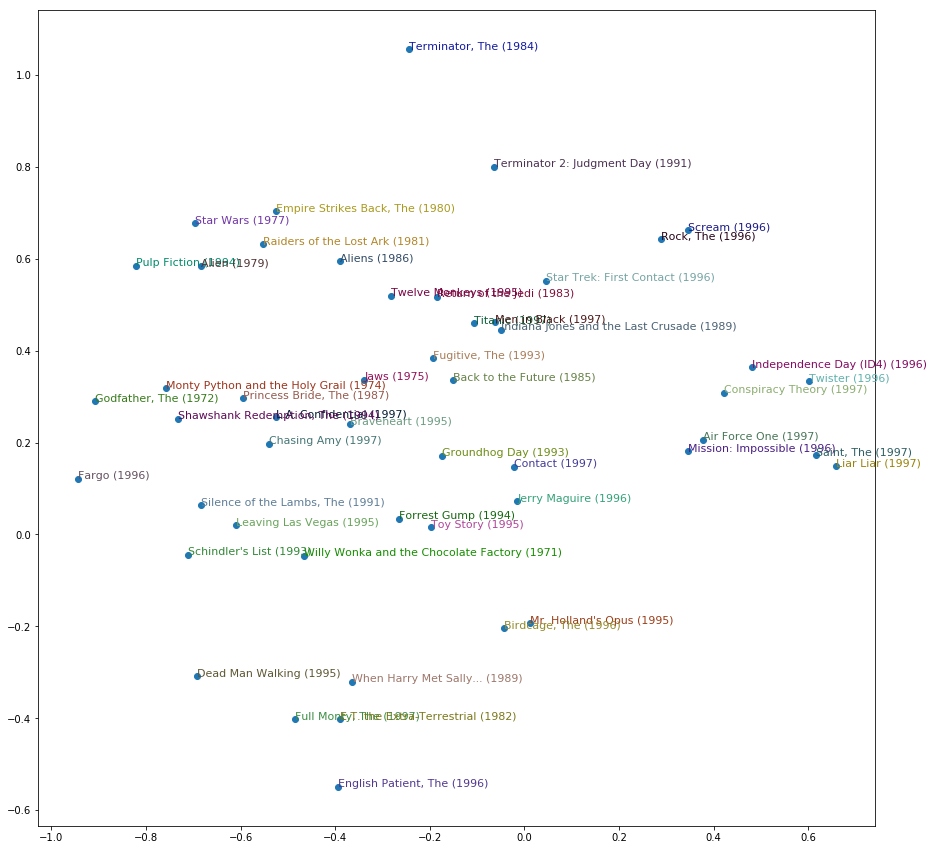

In [35]:
idxs = np.random.choice(len(top_movies), 50, replace=False)
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X,Y)
for i,x,y in zip(top_movies[idxs],X,Y):
    plt.text(x,y,i,color=np.random.rand(3)*0.7, fontsize=11)
plt.show()
